Quick and dirty scripts to have a look at some key quantities of ensemble members.

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [9]:
out_path = './../run_1'
out_path = './../../../fredrik/deep-botany/run_1'

dss = xr.open_dataset(out_path+'/tmser.001.nc')
ds1 = xr.open_dataset(out_path+'/profiles.001.nc')

(0.0, 160.0)

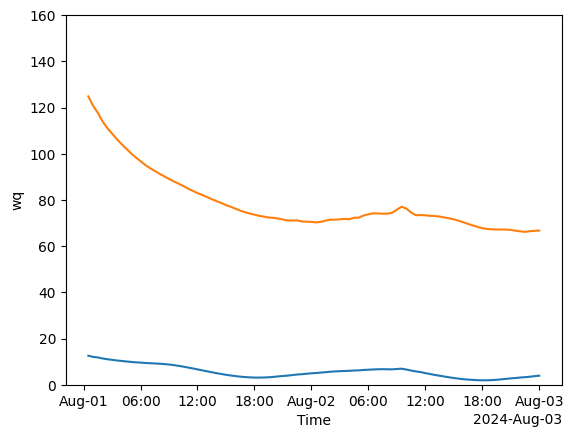

In [10]:
cp=1004.
rho=1.225
Lv = 2.5e6

(cp*rho*dss['wtheta']).plot()
(Lv*rho*dss['wq']).plot()
plt.ylim(0,160)

# (cp*rho*dss['wthetav']).plot()
# (cp*rho*dss['wtheta']).plot()
# (cp*rho*0.61*300*dss['wq']).plot()

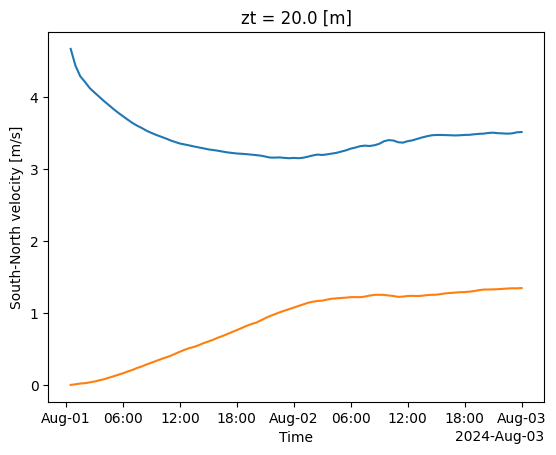

In [11]:
ds1['u'].sel(zt=20).plot()
ds1['v'].sel(zt=20).plot()

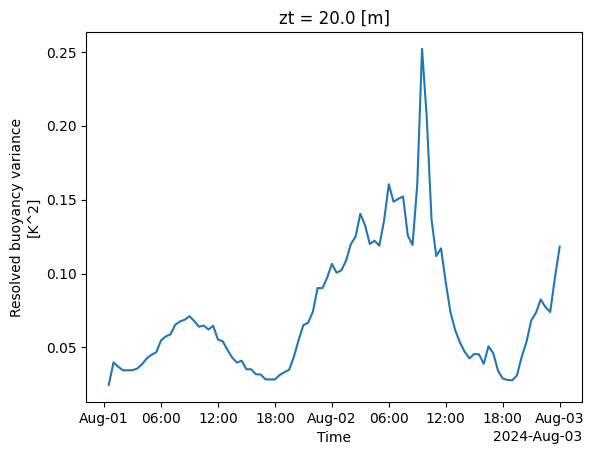

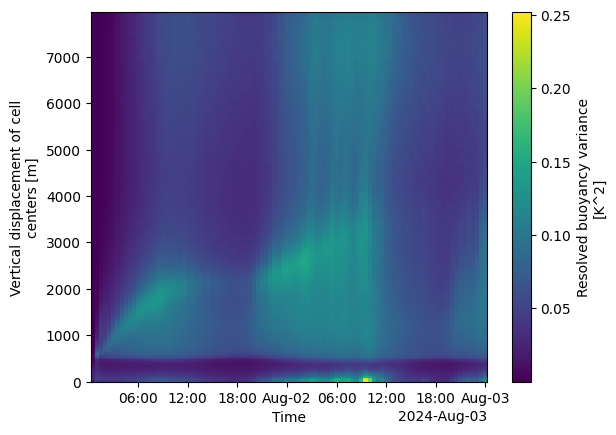

In [12]:
dthv = np.sqrt(ds1['thv2r']).sel(zt=slice(0,8e3))

# Measure of initial parcel buoyancy
dthv.sel(zt=20).plot()
plt.show()
dthv.plot(y='zt')

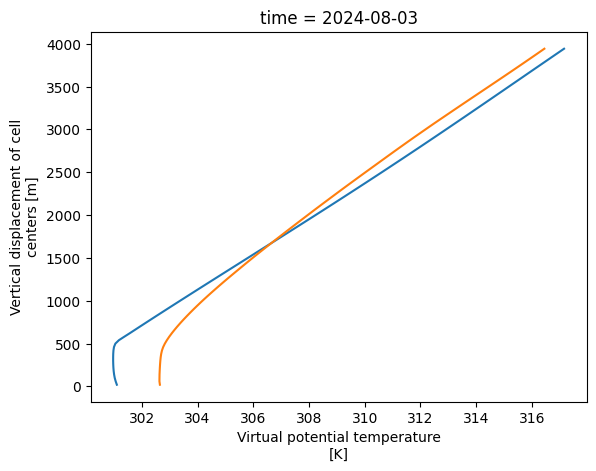

In [13]:
thvp = ds1['thv'].sel(zt=slice(0,4e3))
thvp.isel(time=0).plot(y='zt')
thvp.isel(time=-1).plot(y='zt')

Actual:  <xarray.DataArray 'ta' ()> Size: 4B
array(0.00566962, dtype=float32)
Moist adiabat:  <xarray.DataArray ()> Size: 4B
array(0.0056822, dtype=float32)


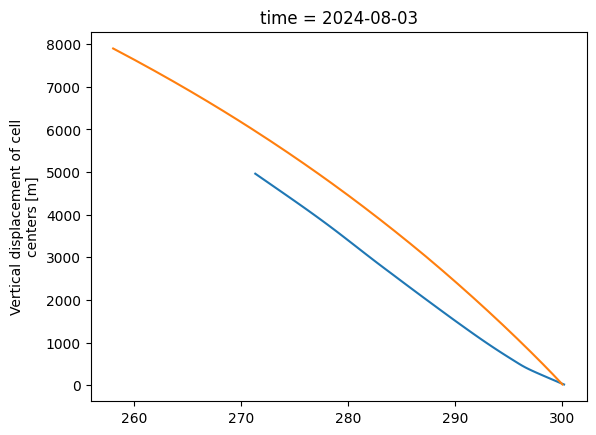

In [14]:
# Moist adiabat of parcel with initial dthv, dqt
grav=9.81
Rd=287.05
Rv=461.5
qs = ds1['hus']/(ds1['hur']/100)

dtdz_ma = (grav + Lv*qs*grav/(Rd*ds1['ta'])) / (cp + qs*Lv**2/(Rv*ds1['ta']**2))
dqsdz = -qs*(Lv*dtdz_ma/(Rv*ds1['ta']**2) - grav/(Rd*ds1['ta']))

ds1['ta'].sel(zt=slice(0,5e3)).isel(time=-1).plot(y='zt')

# For a parcel with an initial t0, q0,
t0 = ds1['ta'].isel(time=-1).sel(zt=20)
dz = ds1['zm'].diff('zm').sel(zm=slice(0,8000))
T_ma = t0 - np.cumsum(dtdz_ma.isel(time=-1).sel(zt=slice(0,8000))*dz.to_numpy())

T_ma.plot(y='zt')

# Actual and ma lapse rates
print('Actual: ',-ds1['ta'].differentiate('zt').sel(zt=slice(2000,10000)).mean())
print('Moist adiabat: ',dtdz_ma.sel(zt=slice(2000,10000)).mean())


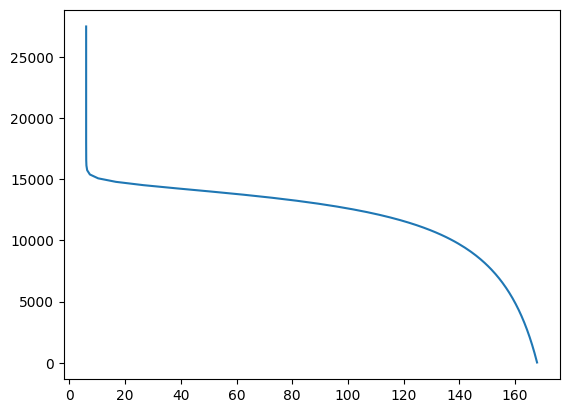

In [16]:
# Nudging functions used in https://doi. org/10.1029/2023MS003796
def _nudge_atan(x, a=5, b=2, c=20, lev_max_change=5000, end=3600*6, test_plot=False):
            y = b * (np.pi/2+np.arctan(a* np.pi/2*(1-x/lev_max_change)))
            y = end + y**c
            # plot
            if test_plot:
                plt.figure(figsize=(6,9))
                plt.plot(y,x)
                plt.xlim([10e3,10e8])
                plt.ylim([0,5000])
                plt.xscale('log')
            return y

def create_nudging(zf, thl, qt, u, v, nudge_params):
    """
    Makes a nudging input file, based on 
    profiles to nudge towards of
    - zf
    - thl
    - qt
    - u
    - v
    nudge_params is a tuple that contains the input parameters to Alessandro's 
    arctangent nudging function.
    """
    
    zero = np.zeros(zf.shape)
    (a,b,c,z_max_change,tnudge_ft) = nudge_params
    
    # Nudging factor with height; 
    # is multiplied with nudging time (tnudgefac) from namelist;
    # here we set tnudgefac=1 -> Then this is the nudging time in seconds
    nudgefac = _nudge_atan(zf,a,b,c,z_max_change,tnudge_ft)
    
    out_profs = np.stack((zf,nudgefac,u,v,zero,thl,qt)).T
    
    return out_profs

tnudge_ft = 6 # hours
lev_max_change = 15000 # m
nudge_params = (10,4.622,5,lev_max_change,tnudge_ft*3600) # ~18 hours near the surface

nudge_profs = create_nudging(ds1['zt'],
                             ds1['thl'].isel(time=0),
                             ds1['qt'].isel(time=0),
                             ds1['u'].isel(time=0),
                             ds1['v'].isel(time=0),
                             nudge_params)
tnudge = nudge_profs[:,1]
plt.plot(tnudge/3600, ds1['zt'])

Text(0.5, 0, 'thl tendencies')

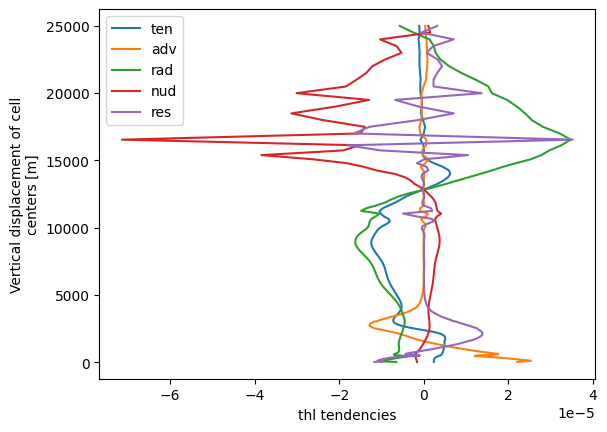

In [17]:
ts='2024-08-02 00:00:00'
te='2024-08-06 00:00:00'
zmax=25000

dsb = ds1.sel(time=slice(ts,te))

dsb['presf'] = dsb['rhof']*Rd*dsb['ta']
exnf = (dsb['presf']/1e5)**(Rd/cp)

# thl
ten = dsb['thl'].differentiate('time', datetime_unit='s')
vad = -(dsb['wthlt']*dsb['rhobh']).differentiate('zm').to_numpy() / dsb['rhobf']
rad = (dsb['thllwtend'] + dsb['thlswtend'])
nud = -(dsb['thl'] - ds1['thl'].isel(time=0))/tnudge
res = ten - (vad + rad + nud)

ten.sel(zt=slice(0,zmax)).mean('time').plot(y='zt', label='ten')
vad.sel(zt=slice(0,zmax)).mean('time').plot(y='zt', label='adv')
rad.sel(zt=slice(0,zmax)).mean('time').plot(y='zt', label='rad')
nud.sel(zt=slice(0,zmax)).mean('time').plot(y='zt', label='nud')
res.sel(zt=slice(0,zmax)).mean('time').plot(y='zt', label='res')
plt.legend()
plt.xlabel('thl tendencies')

Text(0.5, 0, 'qt tendencies')

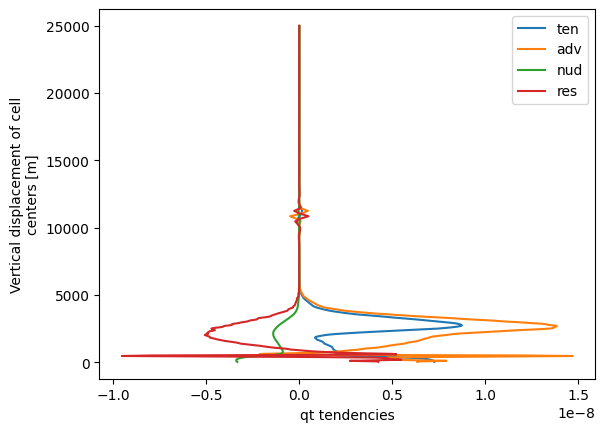

In [18]:
# qt
ten = dsb['qt'].differentiate('time', datetime_unit='s')
vad = -(dsb['wqtt']*dsb['rhobh']).differentiate('zm').to_numpy() / dsb['rhobf']
nud = -(dsb['qt'] - ds1['qt'].isel(time=0))/tnudge
res = ten - (vad + nud) # Mcr

ten.sel(zt=slice(0,zmax)).mean('time').plot(y='zt', label='ten')
vad.sel(zt=slice(0,zmax)).mean('time').plot(y='zt', label='adv')
nud.sel(zt=slice(0,zmax)).mean('time').plot(y='zt', label='nud')
res.sel(zt=slice(0,zmax)).mean('time').plot(y='zt', label='res')
plt.legend()
plt.xlabel('qt tendencies')

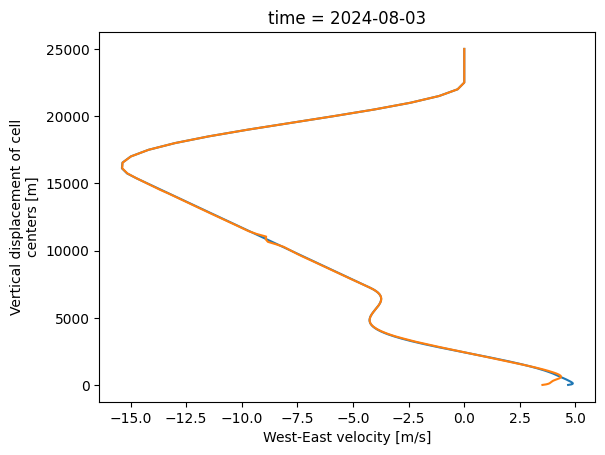

In [19]:
ds1['u'].sel(zt=slice(0,zmax)).isel(time=0).plot(y='zt', label='ten')
ds1['u'].sel(zt=slice(0,zmax)).isel(time=-1).plot(y='zt', label='ten')